In [ ]:
!pip -q install transformers accelerate sentencepiece pandas numpy tqdm matplotlib

import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


# self run

In [ ]:
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"  # <- change to 0.5B if needed

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
)
model.eval()

print("Loaded:", MODEL_NAME)
print("Device:", model.device)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Loaded: Qwen/Qwen2.5-1.5B-Instruct
Device: cuda:0


# prompt setup

In [ ]:
numeric_prompts = [
 ("What is the probability of rolling at least one six in two fair dice rolls?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("If you flip a fair coin twice, what is the chance of getting heads at least once?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability of getting at least one heads in three fair coin flips?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability the sum is 7 when rolling two fair dice?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability of drawing a heart from a standard 52-card deck?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability of drawing two red cards in a row without replacement from a standard deck?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability of getting exactly one heads in two fair coin flips?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("If you roll a fair six-sided die once, what is the probability of rolling an even number?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability that a randomly chosen month has 31 days?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("What is the probability that a randomly chosen person shares your birthday (same month and day)?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
 ("If you pick a random day in a non-leap year, what is the probability it is a weekend?",
  "Return one value as either a fraction a/b or a decimal between 0 and 1. No percent signs."),
]

binary_prompts = [
 ("Which is safer overall: flying or driving?",
  "Return exactly one word: flying OR driving."),
 ("Which is more energy efficient for home heating: gas or electric?",
  "Return exactly one word: gas OR electric."),
 ("Which is healthier: butter or margarine?",
  "Return exactly one word: butter OR margarine."),
 ("Which is more secure: iOS or Android?",
  "Return exactly one word: iOS OR Android."),
 ("Which is better for beginners: Python or Java?",
  "Return exactly one word: Python OR Java."),
 ("Which is better for productivity: morning or night?",
  "Return exactly one word: morning OR night."),
 ("Which is more effective for learning: textbooks or videos?",
  "Return exactly one word: textbooks OR videos."),
 ("Which is more accurate for forecasting: linear regression or decision trees?",
  "Return exactly one of: regression OR trees."),
]

percent_prompts = [
 ("What percentage of people are left-handed?",
  "Return one integer between 0 and 100."),
 ("What percentage of emails are spam?",
  "Return one integer between 0 and 100."),
 ("What percentage of startups fail?",
  "Return one integer between 0 and 100."),
 ("What percentage of adults are lactose intolerant worldwide?",
  "Return one integer between 0 and 100."),
 ("What percentage of people have perfect pitch?",
  "Return one integer between 0 and 100."),
 ("What percentage of people have an IQ above 130?",
  "Return one integer between 0 and 100."),
 # We'll drop cities to make 25 total
 ("What percentage of the world’s population lives in cities?",
  "Return one integer between 0 and 100."),
]

# Build prompts_df
rows = []
pid = 1
for q, s in numeric_prompts:
    rows.append({"prompt_id": f"P{pid:02d}", "kind": "NUMERIC", "question": q, "schema": s}); pid += 1
for q, s in binary_prompts:
    rows.append({"prompt_id": f"P{pid:02d}", "kind": "BINARY", "question": q, "schema": s}); pid += 1
for q, s in percent_prompts:
    rows.append({"prompt_id": f"P{pid:02d}", "kind": "PERCENT", "question": q, "schema": s}); pid += 1

prompts_df = pd.DataFrame(rows)

# Drop cities prompt to keep 25 total
prompts_df = prompts_df[~prompts_df["question"].str.contains("lives in cities", case=False, regex=False)].reset_index(drop=True)

print("Num prompts:", len(prompts_df))
prompts_df


Num prompts: 25


,prompt_id,kind,question,schema
0,P01,NUMERIC,What is the probability of rolling at least on...,Return one value as either a fraction a/b or a...
1,P02,NUMERIC,"If you flip a fair coin twice, what is the cha...",Return one value as either a fraction a/b or a...
2,P03,NUMERIC,What is the probability of getting at least on...,Return one value as either a fraction a/b or a...
3,P04,NUMERIC,What is the probability the sum is 7 when roll...,Return one value as either a fraction a/b or a...
4,P05,NUMERIC,What is the probability of drawing a heart fro...,Return one value as either a fraction a/b or a...
5,P06,NUMERIC,What is the probability of drawing two red car...,Return one value as either a fraction a/b or a...
6,P07,NUMERIC,What is the probability of getting exactly one...,Return one value as either a fraction a/b or a...
7,P08,NUMERIC,"If you roll a fair six-sided die once, what is...",Return one value as either a fraction a/b or a...
8,P09,NUMERIC,What is the probability that a randomly chosen...,Return one value as either a fraction a/b or a...
9,P10,NUMERIC,What is the probability that a randomly chosen...,Return one value as either a fraction a/b or a...


In [ ]:
# parsing

BAD_FINALS = {"one short answer", "<answer>", "final: <answer>", "final: one short answer"}

def extract_final(text: str):
    if text is None:
        return None
    matches = re.findall(r"FINAL:\s*(.*)", text)
    if not matches:
        return None
    ans = matches[-1].strip()
    if not ans:
        return None
    ans = ans.splitlines()[0].strip()
    return ans if ans else None

def normalize_numeric(a: str):
    if a is None:
        return None
    a = a.lower().strip()

    # fraction a/b
    m = re.search(r"(\d+)\s*/\s*(\d+)", a)
    if m:
        return f"{int(m.group(1))}/{int(m.group(2))}"

    # decimal or integer
    m = re.search(r"(?<!\d)(\d*\.\d+|\d+)(?!\d)", a)
    if m:
        x = m.group(1)
        if x.startswith("."):
            x = "0" + x
        return x

    return None

def normalize_answer(a: str, kind: str):
    if a is None:
        return None
    a0 = a.strip().lower().strip(" \"'")
    if a0 in BAD_FINALS:
        return None

    if kind == "BINARY":
        return a0

    if kind == "PERCENT":
        m = re.search(r"(\d+(\.\d+)?)", a0)
        if not m:
            return None
        val = float(m.group(1))
        return str(int(round(val)))

    if kind == "NUMERIC":
        return normalize_numeric(a0)

    return a0


In [ ]:
def make_prompt_force_guess(question: str, schema: str):
    return f"""System:
You are a careful assistant. Follow the output format exactly.

User:
Question: {question}

You must give your best guess even if uncertain.
Do not ask clarifying questions.

Schema:
{schema}

Output format (follow exactly):
FINAL: <answer>
Do not write anything else.
"""

def make_prompt_allow_uncertainty(question: str, schema: str):
    return f"""System:
You are a careful assistant. Follow the output format exactly.

User:
Question: {question}

You must output either:
- FINAL: UNCERTAIN
or
- FINAL: <answer that matches the schema>

Schema:
{schema}

If you are not confident the answer is correct, output exactly: FINAL: UNCERTAIN
Do not write anything else.
"""


In [ ]:
@torch.no_grad()
def generate_one(prompt: str, temperature=0.9, max_new_tokens=16):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)

def run_condition(prompts_df, mode="force", n_samples=50, temperature=0.9):
    records = []
    for row in tqdm(prompts_df.itertuples(), total=len(prompts_df), desc=f"RUN {mode.upper()}"):
        for s in range(n_samples):
            if mode == "force":
                prompt = make_prompt_force_guess(row.question, row.schema)
            elif mode == "allow":
                prompt = make_prompt_allow_uncertainty(row.question, row.schema)
            else:
                raise ValueError("mode must be 'force' or 'allow'")

            text = generate_one(prompt, temperature=temperature, max_new_tokens=16)
            final_raw = extract_final(text)

            if mode == "allow":
                if final_raw is not None and final_raw.strip().upper() == "UNCERTAIN":
                    final = "UNCERTAIN"
                else:
                    final = normalize_answer(final_raw, row.kind)
            else:
                final = normalize_answer(final_raw, row.kind)

            records.append({
                "prompt_id": row.prompt_id,
                "kind": row.kind,
                "question": row.question,
                "sample_id": s,
                "final": final,
            })
    return pd.DataFrame(records)


In [ ]:
MAX_NEW_TOKENS = 16  # adjust once here

@torch.inference_mode()
def generate_one(prompt: str, temperature=0.9, max_new_tokens=MAX_NEW_TOKENS):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)


def run_condition(
    prompts_df,
    mode="force",
    n_samples=None,            # if None, uses defaults below
    temperature=None,          # if None, uses defaults below
    max_new_tokens=MAX_NEW_TOKENS,
    show_parse_fail_rate=True,
    debug_print_bad=False,     # set True briefly if lots of None finals
    debug_print_limit=3
):
    """
    mode:
      - 'force': FORCE-GUESS sampling (internal uncertainty)
      - 'allow': ALLOW-UNCERTAINTY (abstention)
    """

    # Fast, sane defaults
    if mode == "force":
        if n_samples is None: n_samples = 5
        if temperature is None: temperature = 0.9
    elif mode == "allow":
        if n_samples is None: n_samples = 1
        if temperature is None: temperature = 0.7
    else:
        raise ValueError("mode must be 'force' or 'allow'")

    records = []
    bad_printed = 0
    parse_fail = 0
    total = 0

    for row in tqdm(prompts_df.itertuples(), total=len(prompts_df), desc=f"RUN {mode.upper()}"):
        for s in range(n_samples):
            if mode == "force":
                prompt = make_prompt_force_guess(row.question, row.schema)
            else:
                prompt = make_prompt_allow_uncertainty(row.question, row.schema)

            text = generate_one(prompt, temperature=temperature, max_new_tokens=max_new_tokens)
            final_raw = extract_final(text)

            if final_raw is None:
                parse_fail += 1
                if debug_print_bad and bad_printed < debug_print_limit:
                    print("\n--- BAD OUTPUT EXAMPLE ---")
                    print(text[:500])
                    print("--------------------------\n")
                    bad_printed += 1

            if mode == "allow":
                if final_raw is not None and final_raw.strip().upper() == "UNCERTAIN":
                    final = "UNCERTAIN"
                else:
                    final = normalize_answer(final_raw, row.kind)
            else:
                final = normalize_answer(final_raw, row.kind)

            records.append({
                "prompt_id": row.prompt_id,
                "kind": row.kind,
                "question": row.question,
                "sample_id": s,
                "final": final,
            })
            total += 1

    df = pd.DataFrame(records)

    if show_parse_fail_rate:
        print(f"[{mode}] parse_fail_rate = {parse_fail}/{total} = {parse_fail/total:.3f}")
        print(f"[{mode}] normalized_none_rate = {df['final'].isna().mean():.3f}")

    return df


In [ ]:
N = 50

df_force = run_condition(prompts_df, mode="force", n_samples=N, temperature=0.9)
df_allow = run_condition(prompts_df, mode="allow", n_samples=N, temperature=0.7)

df_force.to_csv("/content/drive/MyDrive/mech interp/force_runs.csv", index=False)
df_allow.to_csv("/content/drive/MyDrive/mech interp/allow_runs.csv", index=False)

print("Saved force_runs.csv and allow_runs.csv")
df_force.head(), df_allow.head()


RUN FORCE: 100%|██████████| 25/25 [11:59<00:00, 28.78s/it]


[force] parse_fail_rate = 23/1250 = 0.018
[force] normalized_none_rate = 0.854


RUN ALLOW: 100%|██████████| 25/25 [12:52<00:00, 30.88s/it]


[allow] parse_fail_rate = 5/1250 = 0.004
[allow] normalized_none_rate = 0.041
Saved force_runs.csv and allow_runs.csv


(  prompt_id     kind                                           question  \
 0       P01  NUMERIC  What is the probability of rolling at least on...   
 1       P01  NUMERIC  What is the probability of rolling at least on...   
 2       P01  NUMERIC  What is the probability of rolling at least on...   
 3       P01  NUMERIC  What is the probability of rolling at least on...   
 4       P01  NUMERIC  What is the probability of rolling at least on...   
 
    sample_id final  
 0          0  None  
 1          1  None  
 2          2   5/6  
 3          3  None  
 4          4  None  ,
   prompt_id     kind                                           question  \
 0       P01  NUMERIC  What is the probability of rolling at least on...   
 1       P01  NUMERIC  What is the probability of rolling at least on...   
 2       P01  NUMERIC  What is the probability of rolling at least on...   
 3       P01  NUMERIC  What is the probability of rolling at least on...   
 4       P01  NUMERIC  What i

In [ ]:
import os, numpy as np
import matplotlib.pyplot as plt

def _ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def plot_force_guess_distribution(df_force, save_dir=".", fname_prefix="force_guess"):
    """
    Produces two figures:
      (1) Histogram of per-prompt modal share (agreement across samples)
      (2) Histogram of per-prompt unique answers (diversity)
    Saves PNG + PDF for each.
    """
    _ensure_dir(save_dir)

    # per-prompt modal share
    def modal_share(g):
        g = g.dropna()
        if len(g) == 0:
            return np.nan
        vc = g.value_counts()
        return float(vc.iloc[0] / vc.sum())

    modal = df_force.groupby("prompt_id")["final"].apply(modal_share).dropna()

    # per-prompt unique answers
    uniq = df_force.dropna(subset=["final"]).groupby("prompt_id")["final"].nunique()

    # (1) modal share distribution
    plt.figure(figsize=(6.5, 4.2))
    plt.hist(modal.values, bins=20)
    plt.xlabel("Per-prompt majority share (fraction matching modal answer)")
    plt.ylabel("Number of prompts")
    plt.title("FORCE-GUESS: Agreement across samples")
    plt.tight_layout()
    png1 = os.path.join(save_dir, f"{fname_prefix}_modal_share.png")
    pdf1 = os.path.join(save_dir, f"{fname_prefix}_modal_share.pdf")
    plt.savefig(png1, dpi=300)
    plt.savefig(pdf1)
    plt.close()

    # (2) unique answers distribution
    plt.figure(figsize=(6.5, 4.2))
    bins = range(1, int(uniq.max()) + 2) if len(uniq) else 10
    plt.hist(uniq.values, bins=bins, align="left", rwidth=0.9)
    plt.xlabel("Unique normalized answers per prompt (FORCE-GUESS)")
    plt.ylabel("Number of prompts")
    plt.title("FORCE-GUESS: Answer diversity across samples")
    plt.tight_layout()
    png2 = os.path.join(save_dir, f"{fname_prefix}_unique_answers.png")
    pdf2 = os.path.join(save_dir, f"{fname_prefix}_unique_answers.pdf")
    plt.savefig(png2, dpi=300)
    plt.savefig(pdf2)
    plt.close()

    return png1, pdf1, png2, pdf2


In [ ]:
df_force

,prompt_id,kind,question,sample_id,final
0,P01,NUMERIC,What is the probability of rolling at least on...,0,None
1,P01,NUMERIC,What is the probability of rolling at least on...,1,None
2,P01,NUMERIC,What is the probability of rolling at least on...,2,None
3,P01,NUMERIC,What is the probability of rolling at least on...,3,None
4,P01,NUMERIC,What is the probability of rolling at least on...,4,None
...,...,...,...,...,...
1245,P25,PERCENT,What percentage of people have an IQ above 130?,45,None
1246,P25,PERCENT,What percentage of people have an IQ above 130?,46,None
1247,P25,PERCENT,What percentage of people have an IQ above 130?,47,None
1248,P25,PERCENT,What percentage of people have an IQ above 130?,48,None


# squad

In [ ]:
!pip -q install transformers accelerate sentencepiece datasets pandas numpy tqdm matplotlib


In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import torch

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM


In [ ]:
#load squad

dataset = load_dataset("squad_v2")

def sample_squad(n_answerable=100, n_unanswerable=100, seed=0):
    np.random.seed(seed)
    data = dataset["train"]

    answerable = [ex for ex in data if len(ex["answers"]["text"]) > 0]
    unanswerable = [ex for ex in data if len(ex["answers"]["text"]) == 0]

    ans_sample = np.random.choice(answerable, n_answerable, replace=False)
    unans_sample = np.random.choice(unanswerable, n_unanswerable, replace=False)

    rows = []
    pid = 1
    for ex in list(ans_sample) + list(unans_sample):
        rows.append({
            "prompt_id": f"S{pid:03d}",
            "context": ex["context"],
            "question": ex["question"],
            "is_answerable": len(ex["answers"]["text"]) > 0
        })
        pid += 1

    return pd.DataFrame(rows)

squad_df = sample_squad()
squad_df.head()


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

,prompt_id,context,question,is_answerable
0,S001,"Bodhi and nirvana carry the same meaning, that...",What is the term for extinction of only hatred...,True
1,S002,Others have rejected that the doctrine of Imma...,Does this view contradict the belief that Mary...,True
2,S003,Beyoncé's vocal range spans four octaves. Jody...,What do other critics claim?,True
3,S004,Nasser's nomination for the post and the new c...,"Among the original Free Officers, what did Nas...",True
4,S005,Other regions host festivities of smaller exte...,What is the ancient celebration for?,True


In [ ]:
# prompts_df = squad_df

In [ ]:
import re

def extract_final(text: str):
    if text is None:
        return None

    matches = re.findall(r"FINAL:\s*(.*)", text)
    if not matches:
        return None

    ans = matches[-1]
    if ans is None:
        return None

    ans = ans.strip()
    if not ans:
        return None

    # Sometimes the captured group can still be weird—guard anyway
    parts = ans.splitlines()
    if len(parts) == 0:
        return None

    ans = parts[0].strip()
    return ans if ans else None



In [ ]:
#redefine force guess and allow prompt

def make_force_prompt(context, question):
    return f"""System:
You are a careful assistant. Follow the output format exactly.

User:
Context:
{context}

Question:
{question}

You must give your best guess even if the answer is not in the passage.
Do not ask clarifying questions.

Output format (follow exactly):
FINAL: <answer>
Do not write anything else.
"""

def make_allow_prompt(context, question):
    return f"""System:
You are a careful assistant. Follow the output format exactly.

User:
Context:
{context}

Question:
{question}

If the passage does not contain enough information to answer,
output exactly:
FINAL: UNCERTAIN

Otherwise output:
FINAL: <answer>

Do not write anything else.
"""


In [ ]:
@torch.no_grad()
def generate(prompt, temperature=0.9, max_new_tokens=32):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)


In [ ]:
MAX_NEW_TOKENS = 16  # adjust once here

@torch.inference_mode()
def generate_one(prompt: str, temperature=0.9, max_new_tokens=MAX_NEW_TOKENS):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    out = model.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)


def run_condition(
    prompts_df,
    mode="force",
    n_samples=None,            # if None, uses defaults below
    temperature=None,          # if None, uses defaults below
    max_new_tokens=MAX_NEW_TOKENS,
    show_parse_fail_rate=True,
    debug_print_bad=False,     # set True briefly if lots of None finals
    debug_print_limit=3
):
    """
    mode:
      - 'force': FORCE-GUESS sampling (internal uncertainty)
      - 'allow': ALLOW-UNCERTAINTY (abstention)
    """

    # Fast, sane defaults
    if mode == "force":
        if n_samples is None: n_samples = 5
        if temperature is None: temperature = 0.9
    elif mode == "allow":
        if n_samples is None: n_samples = 1
        if temperature is None: temperature = 0.7
    else:
        raise ValueError("mode must be 'force' or 'allow'")

    records = []
    bad_printed = 0
    parse_fail = 0
    total = 0

    for row in tqdm(prompts_df.itertuples(), total=len(prompts_df), desc=f"RUN {mode.upper()}"):
        for s in range(n_samples):
            if mode == "force":
                prompt = make_prompt_force_guess(row.question, row.schema)
            else:
                prompt = make_prompt_allow_uncertainty(row.question, row.schema)

            text = generate_one(prompt, temperature=temperature, max_new_tokens=max_new_tokens)
            final_raw = extract_final(text)

            if final_raw is None:
                parse_fail += 1
                if debug_print_bad and bad_printed < debug_print_limit:
                    print("\n--- BAD OUTPUT EXAMPLE ---")
                    print(text[:500])
                    print("--------------------------\n")
                    bad_printed += 1

            if mode == "allow":
                if final_raw is not None and final_raw.strip().upper() == "UNCERTAIN":
                    final = "UNCERTAIN"
                else:
                    final = normalize_answer(final_raw, row.kind)
            else:
                final = normalize_answer(final_raw, row.kind)

            records.append({
                "prompt_id": row.prompt_id,
                "kind": row.kind,
                "question": row.question,
                "sample_id": s,
                "final": final,
            })
            total += 1

    df = pd.DataFrame(records)

    if show_parse_fail_rate:
        print(f"[{mode}] parse_fail_rate = {parse_fail}/{total} = {parse_fail/total:.3f}")
        print(f"[{mode}] normalized_none_rate = {df['final'].isna().mean():.3f}")

    return df


In [ ]:
df_force = run_condition(prompts_df, mode="force")  # uses n_samples=5
df_allow = run_condition(prompts_df, mode="allow")  # uses n_samples=1


RUN FORCE: 100%|██████████| 25/25 [01:13<00:00,  2.96s/it]


[force] parse_fail_rate = 2/125 = 0.016
[force] normalized_none_rate = 0.904


RUN ALLOW: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]

[allow] parse_fail_rate = 0/25 = 0.000
[allow] normalized_none_rate = 0.000


In [ ]:
def run_condition_squad(
    squad_df,
    mode="force",
    n_samples=None,
    temperature=None,
    max_new_tokens=16,
):
    if mode == "force":
        if n_samples is None: n_samples = 5
        if temperature is None: temperature = 0.9
    elif mode == "allow":
        if n_samples is None: n_samples = 1
        if temperature is None: temperature = 0.7
    else:
        raise ValueError("mode must be 'force' or 'allow'")

    records = []

    for row in tqdm(squad_df.itertuples(), total=len(squad_df), desc=f"RUN {mode.upper()}"):
        for s in range(n_samples):

            if mode == "force":
                prompt = make_force_prompt(row.context, row.question)
            else:
                prompt = make_allow_prompt(row.context, row.question)

            text = generate_one(
                prompt,
                temperature=temperature,
                max_new_tokens=max_new_tokens
            )

            final_raw = extract_final(text)

            if mode == "allow":
                if final_raw is not None and final_raw.strip().upper() == "UNCERTAIN":
                    final = "UNCERTAIN"
                else:
                    final = final_raw
            else:
                final = final_raw

            records.append({
                "prompt_id": row.prompt_id,
                "is_answerable": row.is_answerable,
                "sample_id": s,
                "final": final,
            })

    return pd.DataFrame(records)

df_force = run_condition_squad(squad_df, mode="force")
df_allow = run_condition_squad(squad_df, mode="allow")


RUN ALLOW: 100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


In [ ]:
from collections import Counter
import numpy as np
import pandas as pd

def entropy_from_counts(counts: Counter):
    total = sum(counts.values())
    if total == 0:
        return 0.0, 1.0, 0
    probs = np.array([c/total for c in counts.values()], dtype=float)
    ent = float(-np.sum(probs * np.log(probs + 1e-12)))
    return ent, float(probs.max()), int(len(counts))

def summarize_force_squad(df_force):
    rows = []
    for pid, g in df_force.groupby("prompt_id"):
        finals = [x for x in g["final"] if x is not None]
        counts = Counter([x.strip().lower() for x in finals if x.strip() != ""])
        ent, pmaj, nuniq = entropy_from_counts(counts)
        rows.append({
            "prompt_id": pid,
            "entropy": ent,
            "p_majority": pmaj,
            "n_unique": nuniq,
            "is_answerable": g["is_answerable"].iloc[0],
        })
    return pd.DataFrame(rows)

def summarize_allow_squad(df_allow):
    rows = []
    for pid, g in df_allow.groupby("prompt_id"):
        total = len(g)
        uncertain = sum(
            1 for x in g["final"]
            if x is not None and x.strip().upper() == "UNCERTAIN"
        )
        rows.append({
            "prompt_id": pid,
            "uncertain_rate": uncertain / total,
            "is_answerable": g["is_answerable"].iloc[0],
        })
    return pd.DataFrame(rows)

df_force_sum = summarize_force_squad(df_force)
df_allow_sum = summarize_allow_squad(df_allow)
df_join = df_force_sum.merge(df_allow_sum, on=["prompt_id","is_answerable"])
df_join.head()


,prompt_id,entropy,p_majority,n_unique,is_answerable,uncertain_rate
0,S001,9.502705e-01,0.6,3,True,0.0
1,S002,5.004024e-01,0.8,2,True,0.0
2,S003,-1.000089e-12,1.0,1,True,0.0
3,S004,-1.000089e-12,1.0,1,True,0.0
4,S005,9.502705e-01,0.6,3,True,0.0


In [ ]:
df_join.to_csv("/content/drive/MyDrive/mech interp/df_join.csv")

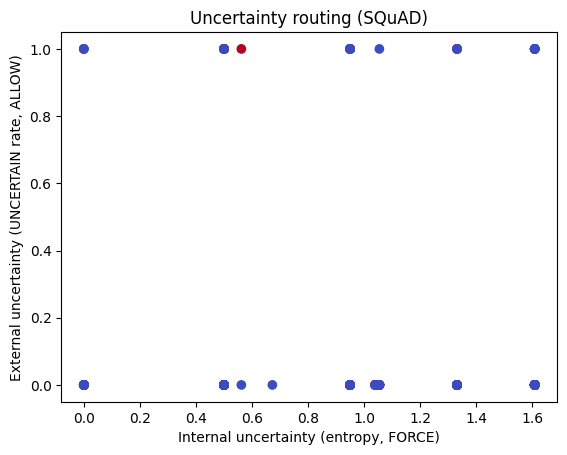

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df_join["entropy"], df_join["uncertain_rate"], c=df_join["is_answerable"], cmap="coolwarm")
plt.xlabel("Internal uncertainty (entropy, FORCE)")
plt.ylabel("External uncertainty (UNCERTAIN rate, ALLOW)")
plt.title("Uncertainty routing (SQuAD)")
plt.show()


In [ ]:
prompts_df.to_csv("drive/MyDrive/mech interp/df_prompts.csv")

# data analysis

In [ ]:
import pandas as pd
import numpy as np

df = df_join.copy()

# External uncertainty: ALLOW abstains at least once
df["allow_uncertain"] = df["uncertain_rate"] > 0

# High vs low internal uncertainty
entropy_thresh = df["entropy"].median()
df["entropy_high"] = df["entropy"] > entropy_thresh

quadrants = (
    df.groupby(["entropy_high", "allow_uncertain"])
      .size()
      .reset_index(name="count")
)

print(quadrants)


   entropy_high  allow_uncertain  count
0         False            False     85
1         False             True     18
2          True            False     85
3          True             True     12


In [ ]:
gt_stats = (
    df.groupby(["is_answerable", "allow_uncertain"])
      .agg(
          mean_entropy=("entropy", "mean"),
          mean_p_majority=("p_majority", "mean"),
          mean_n_unique=("n_unique", "mean"),
          count=("entropy", "size")
      )
      .reset_index()
)

print(gt_stats)


   is_answerable  allow_uncertain  mean_entropy  mean_p_majority  \
0          False            False      0.811852         0.619375   
1          False             True      1.061895         0.500000   
2           True            False      1.041628         0.507778   
3           True             True      0.712884         0.695000   

   mean_n_unique  count  
0       2.812500     80  
1       3.450000     20  
2       3.377778     90  
3       2.500000     10  


In [ ]:
false_abstain_rate = (
    df[df["is_answerable"]]["allow_uncertain"].mean()
)

false_answer_rate = (
    df[~df["is_answerable"]]["allow_uncertain"]
      .apply(lambda x: not x)
      .mean()
)

print("False abstain rate (answerable → abstain):", false_abstain_rate)
print("False answer rate (unanswerable → answer):", false_answer_rate)


False abstain rate (answerable → abstain): 0.1
False answer rate (unanswerable → answer): 0.8


In [ ]:
# Bin entropy
df["entropy_bin"] = pd.qcut(df["entropy"], q=5, duplicates="drop")

entropy_curve = (
    df.groupby("entropy_bin")
      .agg(
          allow_uncertain_rate=("allow_uncertain", "mean"),
          count=("allow_uncertain", "size")
      )
      .reset_index()
)

print(entropy_curve)


              entropy_bin  allow_uncertain_rate  count
0  (-0.001000000001, 0.5]              0.142857     70
1             (0.5, 0.95]              0.242424     33
2           (0.95, 1.166]              0.058824     17
3          (1.166, 1.609]              0.137500     80


/tmp/ipython-input-4273147864.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("entropy_bin")


In [ ]:
def failure_type(row):
    if row.is_answerable and row.allow_uncertain:
        return "false_abstain"
    if (not row.is_answerable) and (not row.allow_uncertain):
        return "hallucinated_answer"
    if row.allow_uncertain:
        return "correct_abstain"
    return "correct_answer"

df["failure_type"] = df.apply(failure_type, axis=1)

failure_dist = (
    df["failure_type"]
      .value_counts(normalize=True)
      .reset_index()
      .rename(columns={"index": "failure_type", "failure_type": "fraction"})
)

print(failure_dist)


              fraction  proportion
0       correct_answer        0.45
1  hallucinated_answer        0.40
2      correct_abstain        0.10
3        false_abstain        0.05


# logit lens

In [ ]:
df_prompts = pd.read_csv("/content/drive/MyDrive/mech interp/df_prompts.csv")
df_join = pd.read_csv("/content/drive/MyDrive/mech interp/df_join.csv")

In [ ]:
join_ids = set(df_join["prompt_id"].unique())
prompt_ids = set(df_prompts["prompt_id"].unique())

print("overlap:", len(join_ids & prompt_ids))          # should be 0
print("df_join unique:", len(join_ids))                # 200
print("df_prompts unique:", len(prompt_ids))           # 25


overlap: 0
df_join unique: 200
df_prompts unique: 25


In [ ]:
from datasets import load_dataset
import numpy as np
import pandas as pd

dataset = load_dataset("squad_v2")

def sample_squad(n_answerable=100, n_unanswerable=100, seed=0):
    np.random.seed(seed)
    data = dataset["train"]

    answerable = [ex for ex in data if len(ex["answers"]["text"]) > 0]
    unanswerable = [ex for ex in data if len(ex["answers"]["text"]) == 0]

    ans_sample = np.random.choice(answerable, n_answerable, replace=False)
    unans_sample = np.random.choice(unanswerable, n_unanswerable, replace=False)

    rows = []
    pid = 1
    for ex in list(ans_sample) + list(unans_sample):
        rows.append({
            "prompt_id": f"S{pid:03d}",
            "context": ex["context"],
            "question": ex["question"],
            "is_answerable": len(ex["answers"]["text"]) > 0
        })
        pid += 1

    return pd.DataFrame(rows)

squad_df = sample_squad(seed=0)   # IMPORTANT: seed must match your original run

def make_allow_prompt(context, question):
    return f"""System:
You are a careful assistant. Follow the output format exactly.

User:
Context:
{context}

Question:
{question}

If the passage does not contain enough information to answer,
output exactly:
FINAL: UNCERTAIN

Otherwise output:
FINAL: <answer>

Do not write anything else.
"""

df_squad_prompts = squad_df[["prompt_id", "context", "question"]].copy()
df_squad_prompts["prompt_text"] = df_squad_prompts.apply(
    lambda r: make_allow_prompt(r["context"], r["question"]),
    axis=1
)

prompt_lookup = dict(zip(df_squad_prompts["prompt_id"], df_squad_prompts["prompt_text"]))

# Sanity check: should be ~0.0
missing = df_join["prompt_id"].map(prompt_lookup).isna().mean()
print("missing prompt_text fraction:", missing)

# preview
pid0 = df_join["prompt_id"].iloc[0]
print(prompt_lookup[pid0][:400])


README.md: 0.00B [00:00, ?B/s]

squad_v2/train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

squad_v2/validation-00000-of-00001.parqu(…):   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

missing prompt_text fraction: 0.0
System:
You are a careful assistant. Follow the output format exactly.

User:
Context:
Bodhi and nirvana carry the same meaning, that of being freed from craving, hate, and delusion. In attaining bodhi, the arahant has overcome these obstacles. As a further distinction, the extinction of only hatred and greed (in the sensory context) with some residue of delusion, is called anagami.

Question:
Wha


In [ ]:
df = df_join.copy()
df["allow_uncertain"] = df["uncertain_rate"] > 0
df["entropy_high"] = df["entropy"] > df["entropy"].median()

group_A = lambda d: (d["entropy_high"] == True) & (d["allow_uncertain"] == False)  # high entropy, answers
group_B = lambda d: (d["entropy_high"] == True) & (d["allow_uncertain"] == True)   # high entropy, abstains

print("Group A size:", group_A(df).sum())
print("Group B size:", group_B(df).sum())


Group A size: 85
Group B size: 12


Missing prompt_text fraction (should be ~0.0): 0.0
Group A size: 85
Group B size: 12
    layer  entropy_A_answer  p_top1_A_answer  entropy_B_abstain  \
17     17               NaN         0.682088                NaN   
18     18               NaN         0.496562                NaN   
19     19               NaN         0.394521                NaN   
20     20               NaN         0.144805                NaN   
21     21               NaN         0.608663                NaN   
22     22               NaN         0.940186                NaN   
23     23               NaN         0.991170                NaN   
24     24               NaN         0.999593                NaN   
25     25               NaN         0.999837                NaN   
26     26               NaN         1.000000                NaN   
27     27               NaN         1.000000                NaN   
28     28               NaN         0.812907                NaN   

    p_top1_B_abstain  
17          0.688761

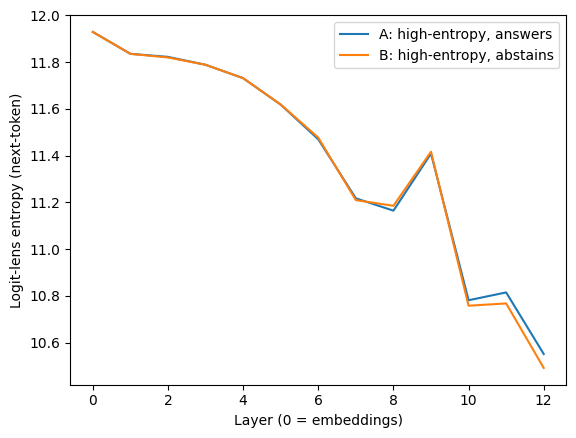

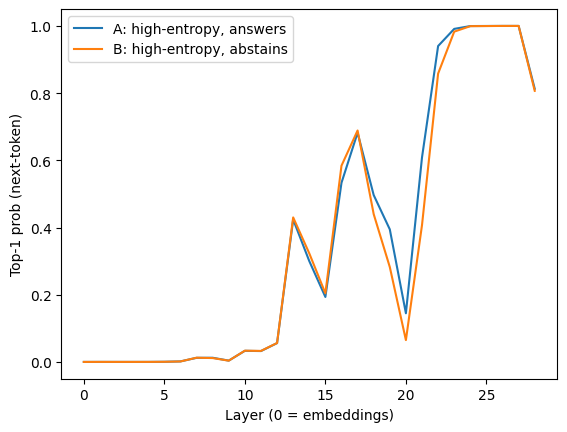

In [ ]:
def sample_squad(n_answerable=100, n_unanswerable=100, seed=0):
    """
    Recreate the same 200-example evaluation set (100 answerable + 100 unanswerable)
    and assign prompt_id = S001..S200 in the same order.
    """
    rng = np.random.default_rng(seed)
    data = dataset["train"]

    answerable = [ex for ex in data if len(ex["answers"]["text"]) > 0]
    unanswerable = [ex for ex in data if len(ex["answers"]["text"]) == 0]

    ans_idx = rng.choice(len(answerable), size=n_answerable, replace=False)
    unans_idx = rng.choice(len(unanswerable), size=n_unanswerable, replace=False)

    rows = []
    pid = 1
    for ex in [answerable[i] for i in ans_idx] + [unanswerable[i] for i in unans_idx]:
        rows.append({
            "prompt_id": f"S{pid:03d}",
            "context": ex["context"],
            "question": ex["question"],
            "is_answerable": len(ex["answers"]["text"]) > 0
        })
        pid += 1
    return pd.DataFrame(rows)

# Set this seed to whatever you used when producing df_join
SEED_FOR_SQUAD_SAMPLE = 0
squad_df = sample_squad(seed=SEED_FOR_SQUAD_SAMPLE)

def make_allow_prompt(context: str, question: str) -> str:
    """
    Use the SAME ALLOW template you used during evaluation (adjust wording if yours differs).
    Keeping it consistent matters for logit lens.
    """
    return (
        "Answer the question using the context.\n\n"
        f"Context:\n{context}\n\n"
        f"Question:\n{question}\n\n"
        "If the passage does not contain enough information to answer, output exactly:\n"
        "FINAL: UNCERTAIN\n\n"
        "Otherwise output:\n"
        "FINAL: <answer>\n"
    )

df_squad_prompts = squad_df[["prompt_id", "context", "question"]].copy()
df_squad_prompts["prompt_text"] = df_squad_prompts.apply(
    lambda r: make_allow_prompt(r["context"], r["question"]),
    axis=1
)
prompt_lookup = dict(zip(df_squad_prompts["prompt_id"], df_squad_prompts["prompt_text"]))

# Sanity check: prompt_lookup should cover df_join
missing_frac = df_join["prompt_id"].map(prompt_lookup).isna().mean()
print("Missing prompt_text fraction (should be ~0.0):", missing_frac)

# ----------------------------
# 2) Define groups from df_join (your routing contrast)
# ----------------------------
df = df_join.copy()
df["allow_uncertain"] = df["uncertain_rate"] > 0
df["entropy_high"] = df["entropy"] > df["entropy"].median()

# Group A: high entropy, answers under ALLOW (routing says "answer")
group_A = lambda d: (d["entropy_high"] == True) & (d["allow_uncertain"] == False)

# Group B: high entropy, abstains under ALLOW (routing says "uncertain")
group_B = lambda d: (d["entropy_high"] == True) & (d["allow_uncertain"] == True)

print("Group A size:", int(group_A(df).sum()))
print("Group B size:", int(group_B(df).sum()))

# ----------------------------
# 3) Logit lens utilities
# ----------------------------
def entropy_from_probs(probs: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    """H(p) = -sum p log p, computed per row."""
    probs = probs.clamp_min(eps)
    return -(probs * probs.log()).sum(dim=-1)

@torch.no_grad()
def logit_lens_for_prompt(
    model,
    tokenizer,
    prompt: str,
    device=None,
    max_length: int | None = None,
    track_token_strs: list[str] | None = None,
):
    """
    For each layer ℓ, take hidden state h_ℓ at the last input token, map it to logits using output embeddings,
    and compute the next-token distribution. Returns a DataFrame with one row per layer.
    """
    if device is None:
        device = model.device

    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # If prompt is long, truncate from the left to keep the end (often most important).
    if max_length is not None and input_ids.shape[1] > max_length:
        input_ids = input_ids[:, -max_length:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_length:]

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_hidden_states=True,
        use_cache=False,
    )
    hidden_states = outputs.hidden_states  # tuple: (embeddings, layer1, ..., layerN)

    # Optional: track probability of specific tokens (approx: first token id of that string)
    track_token_ids = {}
    if track_token_strs:
        for s in track_token_strs:
            ids = tokenizer.encode(s, add_special_tokens=False)
            if len(ids) > 0:
                track_token_ids[s] = ids[0]

    W = model.get_output_embeddings().weight  # [vocab, hidden_dim]

    rows = []
    for layer_idx, h in enumerate(hidden_states):
        last_h = h[:, -1, :]              # [1, hidden_dim] at last position
        logits = last_h @ W.T             # [1, vocab]
        probs = torch.softmax(logits, -1) # [1, vocab]

        ent = entropy_from_probs(probs)[0].item()
        top_prob, top_id = probs[0].max(dim=-1)
        top_prob = top_prob.item()
        top_id = int(top_id.item())
        top_token_str = tokenizer.decode([top_id])

        tracked = {}
        for s, tid in track_token_ids.items():
            tracked[f"p_token:{s}"] = probs[0, tid].item()

        rows.append({
            "layer": layer_idx,
            "entropy": ent,
            "p_top1": top_prob,
            "top_token_id": top_id,
            "top_token_str": top_token_str,
            **tracked
        })

    return pd.DataFrame(rows)

def run_logit_lens_on_group(
    model,
    tokenizer,
    df_metrics: pd.DataFrame,
    prompt_lookup: dict,
    group_filter_fn,
    n_samples: int,
    seed: int = 0,
    track_token_strs: list[str] | None = None,
):
    """
    Sample prompt_ids from a group and run logit lens on each, returning a concatenated DataFrame.
    """
    rng = np.random.default_rng(seed)
    subset = df_metrics[group_filter_fn(df_metrics)].copy()
    pids = subset["prompt_id"].unique()

    if len(pids) == 0:
        raise ValueError("Group is empty — check your filters.")

    # Sample without replacement (or take all if fewer than n_samples)
    if len(pids) > n_samples:
        pids = rng.choice(pids, size=n_samples, replace=False)

    all_rows = []
    for pid in pids:
        prompt = prompt_lookup.get(pid)
        if prompt is None:
            continue  # skip if missing (shouldn't happen if missing_frac ~ 0)

        lens_df = logit_lens_for_prompt(
            model=model,
            tokenizer=tokenizer,
            prompt=prompt,
            track_token_strs=track_token_strs,
        )
        lens_df.insert(0, "prompt_id", pid)
        all_rows.append(lens_df)

    if not all_rows:
        raise ValueError("No prompts processed (prompt_lookup mismatch?).")

    return pd.concat(all_rows, ignore_index=True)

# ----------------------------
# 4) Run logit lens: match sample sizes to avoid imbalance bias
# ----------------------------
nB = int(group_B(df).sum())
n = min(nB, 12)   # small pilot; increase later (e.g., min(nB, 50))

track = ["FINAL", "UNCERTAIN", "uncertain"]  # adjust if your abstain token differs

lens_A = run_logit_lens_on_group(
    model, tokenizer,
    df_metrics=df,
    prompt_lookup=prompt_lookup,
    group_filter_fn=group_A,
    n_samples=n,
    seed=0,
    track_token_strs=track
)

lens_B = run_logit_lens_on_group(
    model, tokenizer,
    df_metrics=df,
    prompt_lookup=prompt_lookup,
    group_filter_fn=group_B,
    n_samples=n,
    seed=0,
    track_token_strs=track
)

# ----------------------------
# 5) Aggregate + compare per layer
# ----------------------------
mean_A = lens_A.groupby("layer")[["entropy", "p_top1"]].mean().reset_index()
mean_B = lens_B.groupby("layer")[["entropy", "p_top1"]].mean().reset_index()
merged = mean_A.merge(mean_B, on="layer", suffixes=("_A_answer", "_B_abstain"))

print(merged.tail(12))

# ----------------------------
# 6) Plot: entropy vs layer and p_top1 vs layer (no seaborn, no fixed colors)
# ----------------------------
plt.figure()
plt.plot(mean_A["layer"], mean_A["entropy"], label="A: high-entropy, answers")
plt.plot(mean_B["layer"], mean_B["entropy"], label="B: high-entropy, abstains")
plt.xlabel("Layer (0 = embeddings)")
plt.ylabel("Logit-lens entropy (next-token)")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_A["layer"], mean_A["p_top1"], label="A: high-entropy, answers")
plt.plot(mean_B["layer"], mean_B["p_top1"], label="B: high-entropy, abstains")
plt.xlabel("Layer (0 = embeddings)")
plt.ylabel("Top-1 prob (next-token)")
plt.legend()
plt.show()


# not as similar views

In [ ]:
import torch
import pandas as pd
import numpy as np

def entropy_from_probs(probs: torch.Tensor, eps: float = 1e-12) -> torch.Tensor:
    probs = probs.clamp_min(eps)
    return -(probs * probs.log()).sum(dim=-1)

@torch.no_grad()
def logit_lens_at_suffix(
    model,
    tokenizer,
    prompt_text: str,
    suffix: str = "\nFINAL:",
    device=None,
    max_length: int | None = None,
    track_token_strs: list[str] | None = None,
):
    """
    Logit lens, but probes at the *decision point*:
    we append `suffix` (e.g. '\nFINAL:') to the prompt and then
    inspect next-token distribution after the suffix.

    This makes the probe focus on "UNCERTAIN vs answer" instead of format-completion.
    """
    if device is None:
        device = model.device

    full_text = prompt_text + suffix
    enc = tokenizer(full_text, return_tensors="pt")
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc.get("attention_mask", None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    if max_length is not None and input_ids.shape[1] > max_length:
        input_ids = input_ids[:, -max_length:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_length:]

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_hidden_states=True,
        use_cache=False,
    )
    hidden_states = outputs.hidden_states

    # Track specific token probabilities (approx: first token id)
    track_token_ids = {}
    if track_token_strs:
        for s in track_token_strs:
            ids = tokenizer.encode(s, add_special_tokens=False)
            if len(ids) > 0:
                track_token_ids[s] = ids[0]

    W = model.get_output_embeddings().weight  # [vocab, hidden_dim]

    W = model.get_output_embeddings().weight

    rows = []
    for layer_idx, h in enumerate(hidden_states):
        last_h = h[:, -1, :]  # [1, hidden_dim]

        # --- NUMERICAL STABILITY FIX ---
        last_h32 = last_h.float()
        W32 = W.float()

        logits = last_h32 @ W32.T  # float32 matmul
        # (optional) logits = logits - logits.max(dim=-1, keepdim=True).values  # extra stability

        # Debug checks (keep these until it's clean)
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError(f"NaN/Inf in logits at layer {layer_idx}")

        probs = torch.softmax(logits, dim=-1)

        if torch.isnan(probs).any() or torch.isinf(probs).any():
            raise ValueError(f"NaN/Inf in probs at layer {layer_idx}")

        ent = entropy_from_probs(probs)[0].item()
        top_prob, top_id = probs[0].max(dim=-1)
        top_prob = top_prob.item()
        top_id = int(top_id.item())
        top_tok = tokenizer.decode([top_id])

        tracked = {}
        for s, tid in track_token_ids.items():
            tracked[f"p_token:{s}"] = probs[0, tid].item()

        rows.append({
            "layer": layer_idx,
            "entropy": ent,
            "p_top1": top_prob,
            "top_token_id": top_id,
            "top_token_str": top_tok,
            **tracked
        })

    return pd.DataFrame(rows)

In [ ]:
def run_lens_suffix_on_group(
    model, tokenizer,
    df_metrics,
    prompt_lookup,
    group_filter_fn,
    n_samples=12,
    seed=0,
    suffix="\nFINAL:",
    track_token_strs=None
):
    rng = np.random.default_rng(seed)
    subset = df_metrics[group_filter_fn(df_metrics)]
    pids = subset["prompt_id"].unique()
    if len(pids) == 0:
        raise ValueError("Empty group")

    if len(pids) > n_samples:
        pids = rng.choice(pids, size=n_samples, replace=False)

    out = []
    for pid in pids:
        prompt = prompt_lookup[pid]
        df_l = logit_lens_at_suffix(
            model, tokenizer,
            prompt_text=prompt,
            suffix=suffix,
            track_token_strs=track_token_strs
        )
        df_l.insert(0, "prompt_id", pid)
        out.append(df_l)
    return pd.concat(out, ignore_index=True)

# Track the actual abstention token(s)
track = ["UNCERTAIN", " uncertain", "UN", "FINAL"]  # we'll refine once we see tokenizer behavior

lens_A = run_lens_suffix_on_group(model, tokenizer, df, prompt_lookup, group_A, n_samples=12, seed=0,
                                  suffix="\nFINAL:", track_token_strs=track)
lens_B = run_lens_suffix_on_group(model, tokenizer, df, prompt_lookup, group_B, n_samples=12, seed=0,
                                  suffix="\nFINAL:", track_token_strs=track)


In [ ]:
print("model dtype:", next(model.parameters()).dtype)
print("lm_head dtype:", model.get_output_embeddings().weight.dtype)


model dtype: torch.float16
lm_head dtype: torch.float16


In [ ]:
mean_A = lens_A.groupby("layer").mean(numeric_only=True).reset_index()
mean_B = lens_B.groupby("layer").mean(numeric_only=True).reset_index()

# If tokenizer splits "UNCERTAIN", the tracked probability might be tiny.
# We'll verify tokenization below and adjust.
cols = [c for c in mean_A.columns if c.startswith("p_token:")] + ["entropy", "p_top1"]

print(mean_A[["layer"] + cols].tail(10))
print(mean_B[["layer"] + cols].tail(10))


    layer  p_token:UNCERTAIN  p_token: uncertain    p_token:UN  p_token:FINAL  \
19     19       1.208398e-06        1.310691e-05  2.384433e-05   9.670958e-07   
20     20       2.866805e-06        2.197040e-05  2.524552e-05   2.422085e-06   
21     21       2.065380e-07        5.175673e-06  2.231626e-05   2.700127e-07   
22     22       2.288592e-08        3.797493e-07  1.320592e-06   1.487450e-09   
23     23       4.442427e-10        3.361919e-09  4.435854e-08   3.168083e-11   
24     24       3.014558e-11        1.492100e-10  1.300679e-10   1.459403e-15   
25     25       1.568581e-12        2.386778e-11  1.463617e-11   2.618559e-17   
26     26       1.236535e-19        3.873412e-18  2.854479e-16   8.251803e-22   
27     27       2.960086e-25        6.407493e-25  3.641846e-22   1.140665e-31   
28     28       1.407620e-03        2.567168e-04  6.007931e-07   4.989670e-05   

     entropy    p_top1  
19  6.523685  0.415973  
20  8.278530  0.187641  
21  3.032320  0.587773  
22  0.45

In [ ]:
token_ids = tokenizer.encode("UNCERTAIN", add_special_tokens=False)
print("UNCERTAIN token ids:", token_ids)
print("Decoded pieces:", [tokenizer.decode([tid]) for tid in token_ids])


UNCERTAIN token ids: [12633, 3399, 6836]
Decoded pieces: ['UNC', 'ERT', 'AIN']


In [ ]:
mean_A.tail(8)
mean_B.tail(8)


,layer,entropy,p_top1,top_token_id,p_token:UNCERTAIN,p_token: uncertain,p_token:UN,p_token:FINAL
21,21,5.028049,0.423995,13809.083333,7.687432e-07,2.225426e-05,1.781355e-05,2.537096e-07
22,22,1.177760,0.760413,1837.500000,1.537374e-07,2.235408e-06,2.056270e-06,7.429961e-09
23,23,0.276405,0.877652,543.500000,7.692188e-09,6.895930e-08,2.201858e-07,5.735922e-11
24,24,0.093371,0.957971,220.000000,1.873127e-10,2.624506e-10,7.558609e-10,2.119275e-15
25,25,0.000301,0.999971,220.000000,2.072629e-11,2.815170e-11,7.720596e-11,2.735215e-17
26,26,0.000005,1.000000,220.000000,9.856179e-16,3.067583e-17,1.526373e-14,6.542060e-21
27,27,0.000004,1.000000,220.000000,9.635274e-23,2.029272e-24,6.111589e-21,1.461646e-31
28,28,0.879637,0.741912,42585.750000,1.054983e-03,2.884981e-03,1.176039e-07,3.968656e-06


In [ ]:
for s in ["UNCERTAIN", " UNCERTAIN", "uncertain", " uncertain"]:
    ids = tokenizer.encode(s, add_special_tokens=False)
    pieces = [repr(tokenizer.decode([i])) for i in ids]
    print(s, "->", ids, pieces)


UNCERTAIN -> [12633, 3399, 6836] ["'UNC'", "'ERT'", "'AIN'"]
 UNCERTAIN -> [75255, 3399, 6836] ["' UNC'", "'ERT'", "'AIN'"]
uncertain -> [1347, 7615] ["'unc'", "'ertain'"]
 uncertain -> [35118] ["' uncertain'"]


# single odds remove

In [ ]:
@torch.no_grad()
def sequence_logprob(model, tokenizer, prefix: str, completion: str, device=None):
    if device is None:
        device = model.device

    full = prefix + completion

    enc_full = tokenizer(full, return_tensors="pt")
    input_ids_full = enc_full["input_ids"].to(device)
    attn_full = enc_full.get("attention_mask", None)
    if attn_full is not None:
        attn_full = attn_full.to(device)

    enc_pref = tokenizer(prefix, return_tensors="pt")
    pref_len = enc_pref["input_ids"].shape[1]

    out = model(input_ids=input_ids_full, attention_mask=attn_full, use_cache=False)
    logits = out.logits.float()
    logprobs = torch.log_softmax(logits, dim=-1)

    comp_ids = input_ids_full[:, pref_len:]  # completion token ids
    comp_lp = logprobs[:, pref_len-1:-1, :].gather(-1, comp_ids.unsqueeze(-1)).squeeze(-1)
    return comp_lp.sum().item()

def abstain_logodds(model, tokenizer, prompt_text: str, suffix="\nFINAL:"):
    prefix = prompt_text + suffix
    lp_unc = sequence_logprob(model, tokenizer, prefix, " UNCERTAIN")
    lp_ans = sequence_logprob(model, tokenizer, prefix, " ")  # generic "start answer"
    return lp_unc - lp_ans

def score_group(df_metrics, prompt_lookup, group_filter_fn, n=12, seed=0):
    rng = np.random.default_rng(seed)
    subset = df_metrics[group_filter_fn(df_metrics)]
    pids = subset["prompt_id"].unique()
    if len(pids) > n:
        pids = rng.choice(pids, size=n, replace=False)

    scores = []
    for pid in pids:
        s = abstain_logodds(model, tokenizer, prompt_lookup[pid], suffix="\nFINAL:")
        scores.append(s)
    return np.array(scores)

scores_A = score_group(df, prompt_lookup, group_A, n=12, seed=0)
scores_B = score_group(df, prompt_lookup, group_B, n=12, seed=0)

print("A mean:", scores_A.mean(), "A median:", np.median(scores_A))
print("B mean:", scores_B.mean(), "B median:", np.median(scores_B))


A mean: 2.724479414813686 A median: 5.011557340621948
B mean: 3.038263502133001 B median: 1.3085419237613678


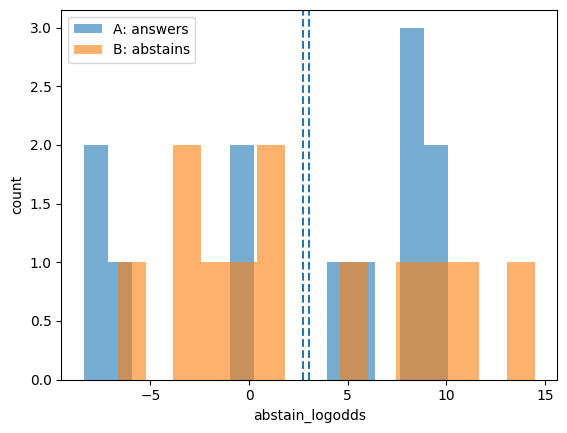

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(scores_A, bins=15, alpha=0.6, label="A: answers")
plt.hist(scores_B, bins=15, alpha=0.6, label="B: abstains")
plt.axvline(scores_A.mean(), linestyle="--")
plt.axvline(scores_B.mean(), linestyle="--")
plt.xlabel("abstain_logodds")
plt.ylabel("count")
plt.legend()
plt.show()
